In [11]:
import numpy as np

In [12]:
class DecisionTree:
    class Node:
        def __init__(self):
            self.attribute = None
            self.split_value = None
            self.entropy = None
            self.samples = None
            self.value = []
            self.left = None
            self.right = None
            self.class_label = None
        
        def print(self, ntab=0):
            if self.class_label is not None:
                print('  '*ntab, '*** leaf ***')
                print('  '*ntab, f'class label: {self.class_label}')
            else:
                print('  '*ntab, '*** internal ***')
            if self.attribute is not None:
                print('  '*ntab, f'attribute: {self.attribute}')
            if self.split_value is not None:
                print('  '*ntab, f'split_value: {self.split_value}')
            print('  '*ntab, f'entropy: {self.entropy}')
            print('  '*ntab, f'samples: {self.samples}')
            print('  '*ntab, f'value: {self.value.tolist()}')
            
            if self.left is not None:
                self.left.print(ntab + 1)
            if self.right is not None:
                self.right.print(ntab + 1)
        
    def __init__(self, size_threshold, purity_threshold, n_classes):
        self.size_threshold = size_threshold
        self.purity_threshold = purity_threshold
        self.n_classes = len(np.unique(y))
        self.root = None
        
    def __initialization(self, X, y):
        return X.shape[0], np.bincount(y), self.__purity(X, y)
    
    def __purity(self, X, y):
        return (np.bincount(y) / X.shape[0]).max()

    def stoping_condition(self, X, y):
        n, n_i, purity = self.__initialization(X, y)
        n_diff_classes = len(n_i[n_i > 0])
        if n <= self.size_threshold or purity >= self.purity_threshold or n_diff_classes == 1:
            class_label = np.argmax(n_i)
            return True, class_label
        return False, None
    
    def print(self):
        self.root.print()
    
    def split_point(self, X, y):
        '''
        Currently supporting only numeric attributes
        '''
        best_score = 0
        split_point = float("inf")
        best_score = -1.0
        for i in range(X.shape[1]):
            point, score = self.evaluate_numeric_attribute(X, y, i)
            if score > best_score:
                best_score = score
                split_point = point
                attribute = i
        return attribute, split_point, best_score
    
    def evaluate_numeric_attribute(self, X, y, i):
        '''
        X - points
        y - targets
        i - index of attribute
        '''
        # sort by column i
        D = np.hstack((X, y.reshape((-1, 1))))
        D = D[D[:, i].argsort(kind='mergesort')]
        target = D[:,-1:].reshape(-1).astype(int)
        D = D[:, :-1]
        # index_0 - class_0, index_1 - class_1, ....
        classes = np.zeros(self.n_classes)
        # max number of mid points
        n_mid_points = D.shape[0] - 1
        mid_points = []
        N = np.zeros((n_mid_points, self.n_classes))
        for j in range(n_mid_points):
            classes[target[j]] += 1
            if D[j, i] == D[j + 1, i]:
                continue
            mid_point = (D[j, i] + D[j + 1, i]) / 2
            mid_points.append(mid_point)
            for k in range(self.n_classes):
                N[len(mid_points) - 1, k] = classes[k]
        classes[target[n_mid_points]] += 1
        # evaluete split point
        best_score = 0.0
        best_mid_point = float("inf")
        for l in range(len(mid_points)):
            P_Y = np.zeros(self.n_classes)
            P_N = np.zeros(self.n_classes)
            n_Y = N[l, :].sum()
            n_N = (classes - N[l, :]).sum()
            for k in range(self.n_classes):
                P_Y[k] = N[l, k] / N[l, :].sum()
                P_N[k] = (classes[k] - N[l, k]) / (classes - N[l, :]).sum()
            score = self.information_gain(D, target, P_Y, P_N, classes, n_Y, n_N)
            if score > best_score:
                best_mid_point = mid_points[l]
                best_score = score
        return best_mid_point, best_score
    
    def information_gain(self, D, target, P_Y, P_N, classes, n_Y, n_N):
        D_entropy = self.node_entropy(target)
        return D_entropy - ((n_Y / (n_Y + n_N)) * self.entropy(P_Y) + (n_N / (n_Y + n_N)) * self.entropy(P_N))
    
    def node_entropy(self, target):
        n = target.shape[0]
        c = np.bincount(target)
        P = c / n
        p = P[P>0]
        log2_p = np.log2(p)
        return -1 * np.dot(p, log2_p)
    
    def entropy(self, P):
        p = P[P>0]
        log2_p = np.log2(p)
        return -1 * np.dot(p, log2_p)

    def build(self, X, y):
        self.root = self.build_r(X, y)
        
    def build_r(self, X, y):
        node = DecisionTree.Node()
        node.entropy = self.node_entropy(y)
        node.samples = X.shape[0]
        node.value = np.bincount(y)
        
        ok, class_label = self.stoping_condition(X, y)
        if ok:
            node.class_label = class_label
            return node

        attribute, split_point, _ = self.split_point(X, y)
        X_Y, X_N, y_Y, y_N = self.split(X, y, attribute, split_point)
        node.left = self.build_r(X_Y, y_Y)
        node.right = self.build_r(X_N, y_N)
        return node
    
    def split(self, X, y, attribute, split_point):
        indices_Y = []
        indices_N = []
        for i in range(X.shape[0]):
            if X[i, attribute] <= split_point:
                indices_Y.append(i)
            else:
                indices_N.append(i)
        return np.take(X, indices_Y, axis=0).copy(), np.take(X, indices_N, axis=0).copy(), np.take(y, indices_Y).copy(), np.take(y, indices_N).copy()
        
        
        

In [13]:
# X = np.array([[1.0, 1, 1, 5.0], 
#               [2.0, 1, 1, 7.0], 
#               [3.0, 1, 0, 8.0], 
#               [4.0, 0, 0, 3.0], 
#               [5.0, 0, 1, 7.0], 
#               [6.0, 0, 1, 4.0], 
#               [7.0, 0, 0, 5.0], 
#               [8.0, 1, 0, 6.0], 
#               [9.0, 0, 1, 1.0]])
X = np.array([[1, 1, 5.0], 
              [1, 1, 7.0], 
              [1, 0, 8.0], 
              [0, 0, 3.0], 
              [0, 1, 7.0], 
              [0, 1, 4.0], 
              [0, 0, 5.0], 
              [1, 0, 6.0], 
              [0, 1, 1.0]])
y = np.array([1, 1, 0, 1, 0, 0, 0, 1, 0])

In [14]:
dt = DecisionTree(1, 100, 2)
dt.build(X, y)
dt.print()

 *** internal ***
 entropy: 0.9910760598382222
 samples: 9
 value: [5, 4]
   *** internal ***
   entropy: 0.7219280948873623
   samples: 5
   value: [4, 1]
     *** internal ***
     entropy: 1.0
     samples: 2
     value: [1, 1]
       *** leaf ***
       class label: 1
       entropy: -0.0
       samples: 1
       value: [0, 1]
       *** leaf ***
       class label: 0
       entropy: -0.0
       samples: 1
       value: [1]
     *** leaf ***
     class label: 0
     entropy: -0.0
     samples: 3
     value: [3]
   *** internal ***
   entropy: 0.8112781244591328
   samples: 4
   value: [1, 3]
     *** leaf ***
     class label: 1
     entropy: -0.0
     samples: 3
     value: [0, 3]
     *** leaf ***
     class label: 0
     entropy: -0.0
     samples: 1
     value: [1]


In [15]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [16]:
dt = DecisionTree(0.95, 5, 3)
dt.build(X, y)
dt.print()

 *** internal ***
 entropy: 1.584962500721156
 samples: 150
 value: [50, 50, 50]
   *** leaf ***
   class label: 0
   entropy: -0.0
   samples: 50
   value: [50]
   *** internal ***
   entropy: 1.0
   samples: 100
   value: [0, 50, 50]
     *** internal ***
     entropy: 0.44506485705083865
     samples: 54
     value: [0, 49, 5]
       *** internal ***
       entropy: 0.1460942501201363
       samples: 48
       value: [0, 47, 1]
         *** leaf ***
         class label: 1
         entropy: -0.0
         samples: 47
         value: [0, 47]
         *** leaf ***
         class label: 2
         entropy: -0.0
         samples: 1
         value: [0, 0, 1]
       *** internal ***
       entropy: 0.9182958340544896
       samples: 6
       value: [0, 2, 4]
         *** leaf ***
         class label: 2
         entropy: -0.0
         samples: 3
         value: [0, 0, 3]
         *** internal ***
         entropy: 0.9182958340544896
         samples: 3
         value: [0, 2, 1]
           

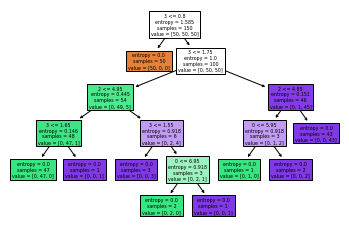

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt


tree_model = DecisionTreeClassifier(criterion='entropy',
                                    random_state=1)
tree_model.fit(X, y)

feature_names = ['0', '1', '2', '3', '4']

tree.plot_tree(tree_model,
               feature_names=feature_names,
               filled=True)

plt.show()